<a href="https://colab.research.google.com/github/Gopi138942/Auto_Encoder/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install CUDA if not already installed. Only run this cell once.
!apt-get install nvidia-cuda-toolkit




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (11.5.1-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [2]:
# Verify CUDA installation:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os


class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector


In [4]:
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector

In [5]:
def prepare_train_validation_movielens_step1():
    rat = pd.read_csv("/content/ratings.csv")
    mov = pd.read_csv("/content/movies.csv")
    df_combined = pd.merge(rat, mov, on = 'movieId')
    print(rat.describe())
    ts = rat['timestamp'].quantile(0.98)
    train_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    validation_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    for i in range(len(rat)):
        if rat['timestamp'].iloc[i] <= ts:
            train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        else:
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        if i%10000 == 0:
            print(i, "Completed")
    print(len(train_ratings))
    print(len(validation_ratings))
    # Remove users in validation set those are not present in Training Set
    train_users = train_ratings['userId'].unique()
    users_not_in_train_set = []

    for i in range(1,611):
        if i in train_users:
            continue
        else:
            users_not_in_train_set.append(i)

    for i in users_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['userId']!=i]

    validation_ratings.reset_index(drop=True)

    print(len(train_ratings['movieId'].unique()))
    print(len(validation_ratings['movieId'].unique()))
    # Remove Movies that are not in the Train Set
    validation_movies = validation_ratings['movieId'].unique()
    train_movies = train_ratings['movieId'].unique()
    movies_not_in_train_set = []

    for i in validation_movies:
        if i in train_movies:
            continue
        else:
            movies_not_in_train_set.append(i)

    for i in movies_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['movieId']!=i]

    validation_ratings.reset_index(drop=True)
    print('Train Users: ', train_ratings['userId'].nunique())
    print('Validation Users: ',validation_ratings['userId'].nunique())
    print('Train Movies: ',train_ratings['movieId'].nunique())
    print('Validation Movies: ',validation_ratings['movieId'].nunique())
    train_ratings.to_csv("/content/train_ratings.csv")
    validation_ratings.to_csv("/content/validation_ratings.csv")



In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def prepare_traintest_movielens_step2():
    tr_ratings = pd.read_csv('/content/train_ratings.csv')
    val_ratings = pd.read_csv('/content/validation_ratings.csv')
    train_dataset = tr_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
    train_dataset.fillna(0, inplace=True)
    print(train_dataset.head(10))
    test_dataset = val_ratings.pivot_table(index='userId', columns='movieId', values='rating')
    test_dataset.fillna(0, inplace=True)
    print(test_dataset.head(10))
    train_dataset.to_csv('/content/train.csv')
    test_dataset.to_csv('/content/test.csv')



In [8]:

def get_traintestloaders():
    transformations = transforms.Compose([transforms.ToTensor()])
    train_dat = TrainDataset('/content/train.csv', transformations)
    test_dat = TestDataset('/content/test.csv', transformations)
    train_loader = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True, num_workers = 1)
    test_loader = DataLoader(dataset=test_dat, batch_size=128, shuffle=True, num_workers=1)
    return train_loader, test_loader

In [26]:

class MSELoss_with_Mask(nn.Module):
    def __init__(self):
        super(MSELoss_with_Mask,self).__init__()

    def forward(self,inputs, targets):
        # Masking into a vector of 1's and 0's.
        mask = (targets!=0)
        mask = mask.float()
        # Actual number of ratings.
        # Take max to avoid division by zero while calculating loss.
        other = torch.Tensor([1.0])
        #other = other.cuda()
        number_ratings = torch.max(torch.sum(mask),other)
        error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
        loss = error.div(number_ratings)
        return loss[0]


In [10]:

import torch.nn.functional as F
import torch.nn.init as init

class AutoEncoder(nn.Module):
    def __init__(self, encoder_layers_sizes, activation = 'ReLU'):
        super(AutoEncoder, self).__init__()
        # Add your code here
        activation_fn = nn.ReLU() if activation == 'Relu' else nn.Sigmoid()

        #Encoder
        self.encoder = nn.Sequential(
            nn.Linear(encoder_layers_sizes[0], encoder_layers_sizes[1]),
            activation_fn,
            nn.Linear(encoder_layers_sizes[1], encoder_layers_sizes[2]),
            activation_fn,
            nn.Linear(encoder_layers_sizes[2], encoder_layers_sizes[3]),
            activation_fn
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoder_layers_sizes[3], encoder_layers_sizes[2]),
            activation_fn,
            nn.Linear(encoder_layers_sizes[2], encoder_layers_sizes[1]),
            activation_fn,
            nn.Linear(encoder_layers_sizes[1], encoder_layers_sizes[0]),
            activation_fn
        )

    def forward(self,x):
        # Forward Pass
        x = x.float()#convert input to float32
        return self.decoder(self.encoder(x))

In [31]:

import torch.optim as optim

def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=50):
    # Add your code here
    train_losses, test_losses = [], []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Move the model and loss function to the device
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, data in enumerate(train_dl):
            data = data.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dl.dataset)
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_idx, data in enumerate(test_dl):
                data = data.to(device)

                outputs = model(data)
                loss = criterion(outputs, data)
                test_loss += loss.item()
                test_loss /= len(test_dl.dataset)
            test_losses.append(test_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    plt.figure(figsize=(10, 6))




    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()

    return train_losses, test_losses

In [12]:
prepare_train_validation_movielens_step1()

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
0 Completed


<ipython-input-5-cfbfd20d9fbf>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
<ipython-input-5-cfbfd20d9fbf>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])


10000 Completed
20000 Completed
30000 Completed
40000 Completed
50000 Completed
60000 Completed
70000 Completed
80000 Completed
90000 Completed
100000 Completed
98819
100836
9559
9608
Train Users:  595
Validation Users:  595
Train Movies:  9559
Validation Movies:  9559


In [13]:
prepare_traintest_movielens_step2()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6           0.0     4.0     5.0     3.0     5.0     4.0     4.0     3.0   
7           4.5     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8           0.0     4.0     0.0     0.0     0.0     0.0     0.0     0.0   
9           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  184349  184471  184791  185029  185031  185135  \
userId             

In [14]:
train_loader, test_loader = get_traintestloaders()

In [15]:
encoder_layers_sizes = [9559, 512, 512, 1024]

In [16]:
model = AutoEncoder(encoder_layers_sizes, activation = 'Relu')

In [18]:

model = model.cpu()

In [27]:
criterion = MSELoss_with_Mask()

In [28]:
criterion = criterion.cpu()

In [29]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/40, Train Loss: 0.0255, Test Loss: 0.0052
Epoch 2/40, Train Loss: 0.0256, Test Loss: 0.0045
Epoch 3/40, Train Loss: 0.0256, Test Loss: 0.0055
Epoch 4/40, Train Loss: 0.0253, Test Loss: 0.0051
Epoch 5/40, Train Loss: 0.0253, Test Loss: 0.0049
Epoch 6/40, Train Loss: 0.0252, Test Loss: 0.0052
Epoch 7/40, Train Loss: 0.0252, Test Loss: 0.0052
Epoch 8/40, Train Loss: 0.0250, Test Loss: 0.0050
Epoch 9/40, Train Loss: 0.0251, Test Loss: 0.0050
Epoch 10/40, Train Loss: 0.0249, Test Loss: 0.0050
Epoch 11/40, Train Loss: 0.0246, Test Loss: 0.0048
Epoch 12/40, Train Loss: 0.0248, Test Loss: 0.0049
Epoch 13/40, Train Loss: 0.0247, Test Loss: 0.0046
Epoch 14/40, Train Loss: 0.0246, Test Loss: 0.0048
Epoch 15/40, Train Loss: 0.0246, Test Loss: 0.0050
Epoch 16/40, Train Loss: 0.0244, Test Loss: 0.0048
Epoch 17/40, Train Loss: 0.0244, Test Loss: 0.0049
Epoch 18/40, Train Loss: 0.0242, Test Loss: 0.0051
Epoch 19/40, Train Loss: 0.0243, Test Loss: 0.0047
Epoch 20/40, Train Loss: 0.0241, Test Lo

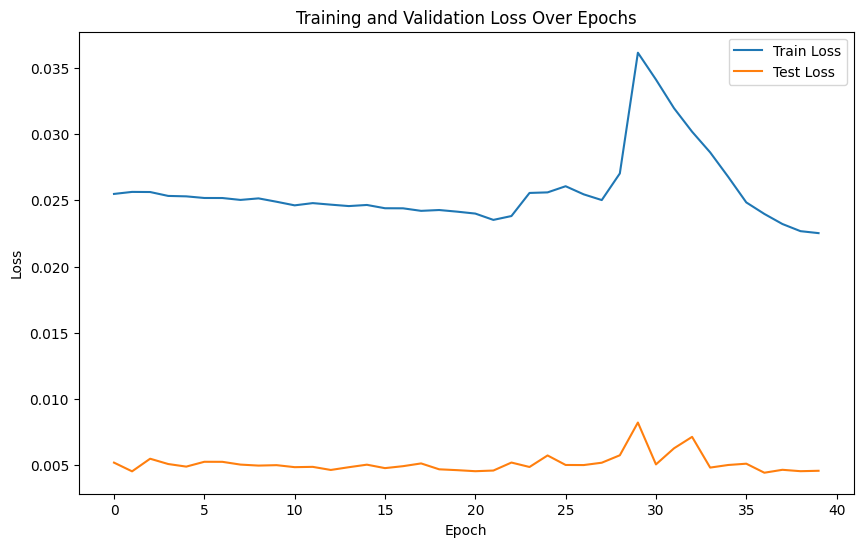

In [32]:
out = train(model, criterion, optimizer, train_loader, test_loader, 40)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [36]:
import matplotlib.pyplot as plt
import torch.optim as optim
import torch

# Function to recommend items for a specific user
def recommend_for_user(model, user_ratings, top_n=5, device='cpu'):
    """
    Generate recommendations for a single user based on their existing ratings.

    Parameters:
    - model: Trained AutoEncoder model
    - user_ratings: Tensor of the user's ratings (with 0 for unrated items)
    - top_n: Number of top recommendations to return
    - device: Device on which the model runs ('cpu' or 'cuda')

    Returns:
    - List of indices representing the recommended items
    """
    # Move user_ratings to the correct device and ensure it's float32
    user_ratings = user_ratings.to(device).float().unsqueeze(0)  # Add batch dimension

    # Pass the user ratings through the autoencoder to get reconstructed ratings
    model.eval()
    with torch.no_grad():
        reconstructed_ratings = model(user_ratings).squeeze(0)  # Remove batch dimension

    # Mask out already-rated items by setting their scores to a very low value
    mask = user_ratings.squeeze(0) == 0  # True for unrated items
    masked_ratings = reconstructed_ratings * mask  # Set rated items' scores to 0

    # Get indices of the top N recommendations
    recommended_indices = torch.argsort(masked_ratings, descending=True)[:top_n]

    return recommended_indices.tolist()

In [37]:
 # Generate recommendations for a sample user
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=9559, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=9559, bias=True)
    (5): ReLU()
  )
)

In [38]:
sample_user_ratings = next(iter(train_loader))  # Get a batch of user ratings from the training data

In [39]:
user_idx = 0  # Index of the user in the batch to generate recommendations

In [41]:
  # Get reconstructed ratings
with torch.no_grad():
    reconstructed_data = model(sample_user_ratings[user_idx].to(device).float())

print("Original ratings for the user:")
print(sample_user_ratings[user_idx])

print("\nReconstructed (predicted) ratings for the user:")
print(reconstructed_data)


Original ratings for the user:
tensor([4., 0., 4.,  ..., 0., 0., 0.], dtype=torch.float64)

Reconstructed (predicted) ratings for the user:
tensor([4.7436, 4.3404, 4.3514,  ..., 4.2099, 4.3169, 1.0630])


In [40]:
recommendations = recommend_for_user(model, sample_user_ratings[user_idx], top_n=5, device=device)
print(f"Top recommendations for user {user_idx + 1}: {recommendations}")

Top recommendations for user 1: [6006, 5173, 9168, 8880, 4574]
